# Driverless AI: Comparing Algorithm Families

This notebook walks through how to build experiments using only certain families of algorithms and then comparing them. This would allow for understanding the trade off of algorithm complexity vs. the accuracy of the final model.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-Setup" data-toc-modified-id="Notebook-Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook Setup</a></span></li><li><span><a href="#Connect-to-Driverless-AI" data-toc-modified-id="Connect-to-Driverless-AI-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Connect to Driverless AI</a></span></li><li><span><a href="#Load-a-Dataset" data-toc-modified-id="Load-a-Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load a Dataset</a></span></li><li><span><a href="#Split-Dataset" data-toc-modified-id="Split-Dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Split Dataset</a></span></li><li><span><a href="#Run-Experiments" data-toc-modified-id="Run-Experiments-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Run Experiments</a></span></li><li><span><a href="#View-Results" data-toc-modified-id="View-Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>View Results</a></span></li></ul></div>

## Notebook Setup

* This notebook uses the beta python client - if you would like to be a beta tester please reach out to your H2O.ai contact
* This notebook has been written and tested in 1.8.6
* Python >= 3.6 is required
* You can use `Shift+Tab` to the see the signature and docstring of any function while using Jupyter

In [1]:
import pandas as pd # local data manipulation
import matplotlib.pyplot as plt # plot results
import getpass # keep password out of the notebook
import driverlessai # connect to DAI

%matplotlib inline
%load_ext autotime

## Connect to Driverless AI
* Create a connection object for interacting with DAI 
* Print and login to the GUI

<br/> **Note:** Click the DAI URL and log in now as you have the password saved to save time later in this notebook

In [2]:
address = 'http://localhost:12345'
username = 'h2oai'

dai = driverlessai.Client(address = address, 
                          username = username, 
                          password = getpass.getpass("Enter your Driverless AI password: "))

Enter your Driverless AI password: ········
time: 5.46 s


In [3]:
dai.server.gui()

'http://localhost:12345'

time: 3.38 ms


## Load a Dataset
Most DAI instances come with some sample data in the `data` folder on the server. We will load in a dataset about customers who may churn from a telco.

* Load a dataset from the DAI server
* Print columns in the dataset
* Create a variables to use in modeling
* Look at the distribution of the target column
* ~~Add the dataset to the project~~

In [4]:
dai_data = dai.datasets.create('/data/churn.csv', data_source="file")

Complete 100.00% - [4/4] Computing column statistics
time: 1.12 s


In [5]:
dai_data.columns

['State',
 'Account Length',
 'Area Code',
 'Phone',
 "Int'l Plan",
 'VMail Plan',
 'VMail Message',
 'Day Mins',
 'Day Calls',
 'Day Charge',
 'Eve Mins',
 'Eve Calls',
 'Eve Charge',
 'Night Mins',
 'Night Calls',
 'Night Charge',
 'Intl Mins',
 'Intl Calls',
 'Intl Charge',
 'CustServ Calls',
 'Churn?']

time: 2.2 ms


In [6]:
# Informatin to use in modeling
col_y = "Churn?"
scoring_metric = "AUC"
cols_to_drop = []
use_case = "classification" # "regression"

# Fast settings for test, longer settings for real experimentation
accuracy = 1
time = 1
interpretability = 6

time: 893 µs


In [7]:
print(dai_data.column_summaries([col_y]))

--- Churn? ---

 False.|████████████████████
  True.|███

Data Type: str
Logical Types: []
Datetime Format: 
Count: 3333
Missing: 0
Unique: 2
Freq: 483


time: 14.8 ms


## Split Dataset
* Create training and testing datasets

In [8]:
dai_data_split = dai_data.split_to_train_test(
    train_size=0.8, 
    train_name=dai_data.name + '_train', 
    test_name=dai_data.name + '_test', 
    target_column= col_y,
    seed=42
)

Complete
time: 2.19 s


In [9]:
dai_data_split

{'train_dataset': <class 'driverlessai._datasets.Dataset'> 22125c8a-9ae5-11ea-bf49-0242ac110002 churn.csv_train,
 'test_dataset': <class 'driverlessai._datasets.Dataset'> 22153e64-9ae5-11ea-bf49-0242ac110002 churn.csv_test}

time: 1.85 ms


## Run Experiments
* List all algorithms available on the system
* Create a dictionary of model families
* Run an experiment for each model family

In [10]:
[m.name for m in dai.recipes.models.list()]

['CONSTANT',
 'DECISIONTREE',
 'FTRL',
 'GLM',
 'IMBALANCEDLIGHTGBM',
 'IMBALANCEDXGBOOSTGBM',
 'LIGHTGBM',
 'RULEFIT',
 'TENSORFLOW',
 'XGBOOSTDART',
 'XGBOOSTGBM']

time: 132 ms


In [11]:
# Remove CONSTANT Model before DAI 1.8.4
model_families = [{"name": "Constant", "models": ['CONSTANT'], "complexity": 0},
                  {"name": "Regression", "models": ['GLM'], "complexity": 1},
                  {"name": "Decision Tree", "models": ['DECISIONTREE'], "complexity": 1},
                  {"name": "Boosting Trees", "models": ['LIGHTGBM', 'XGBOOSTDART', 'XGBOOSTGBM'], "complexity": 2},
                  {"name": "Neural Net", "models": ['TENSORFLOW'], "complexity": 3}
                 ]

time: 964 µs


In [12]:
# As we are testing we don't need scoring pipelines etc.
fast_settings = {
    'make_python_scoring_pipeline': 'off',
    'make_mojo_scoring_pipeline': 'off',
    'benchmark_mojo_latency': 'off',
    'make_autoreport': False,
    'check_leakage': 'off',
    'check_distribution_shift': 'off'
}

time: 588 µs


In [13]:
results = pd.DataFrame()

for m in model_families:
    # Run the experiment
    experiment = dai.experiments.create(name=m["name"],
                                        **dai_data_split,
                                        target_column=col_y,
                                        task=use_case,
                                        accuracy=accuracy, time=time, interpretability=interpretability,
                                        scorer=scoring_metric,
                                        models=m["models"],
                                        drop_columns=cols_to_drop,
                                        **fast_settings 
                                        )

    # add validation results to our dataframe
    exp_results = pd.DataFrame([{'name': m["name"],
                                 'complexity': m["complexity"], 
                                 'validation_score': experiment.metrics()["val_score"],
                                 'test_score': experiment.metrics()["test_score"],
                                 'experiment_id': experiment.key}])
    print()
    print(exp_results)
    
    results = pd.concat([results, exp_results], axis = 0)


Experiment launched at: http://localhost:12345/#experiment?key=238002ca-9ae5-11ea-bf49-0242ac110002
Complete 100.00% - Status: Complete                                           

       name  complexity  validation_score  test_score  \
0  Constant           0            0.4841         0.5   

                          experiment_id  
0  238002ca-9ae5-11ea-bf49-0242ac110002  
Experiment launched at: http://localhost:12345/#experiment?key=3eaeef8e-9ae5-11ea-bf49-0242ac110002
Complete 100.00% - Status: Complete                                           

         name  complexity  validation_score  test_score  \
0  Regression           1          0.795516    0.819913   

                          experiment_id  
0  3eaeef8e-9ae5-11ea-bf49-0242ac110002  
Experiment launched at: http://localhost:12345/#experiment?key=770f0c06-9ae5-11ea-bf49-0242ac110002
Complete 100.00% - Status: Complete                                               

            name  complexity  validation_score  test_s

## View Results
* View resulting table
* View plot of accuracy by model family

In [14]:
results

,name,complexity,validation_score,test_score,experiment_id
0,Constant,0,0.484100,0.500000,238002ca-9ae5-11ea-bf49-0242ac110002
0,Regression,1,0.795516,0.819913,3eaeef8e-9ae5-11ea-bf49-0242ac110002
0,Decision Tree,1,0.888221,0.857623,770f0c06-9ae5-11ea-bf49-0242ac110002
0,Boosting Trees,2,0.920034,0.892060,a94af54a-9ae5-11ea-bf49-0242ac110002
0,Neural Net,3,0.807313,0.852198,e56a2820-9ae5-11ea-bf49-0242ac110002


time: 13.8 ms


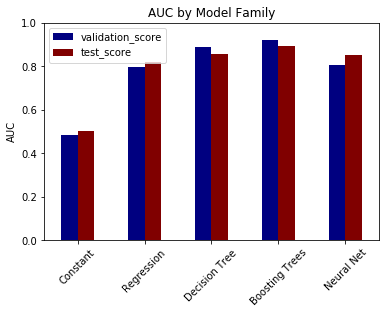

time: 200 ms


In [15]:
results.plot(x="name", 
             y=["validation_score", "test_score"], 
             kind="bar", 
             title= scoring_metric + " by Model Family",
             colormap='jet',
             ylim=(0,1))


plt.xlabel('')
plt.xticks(rotation=45 )
plt.ylabel(scoring_metric)
plt.show()